[[1. 1. 0. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


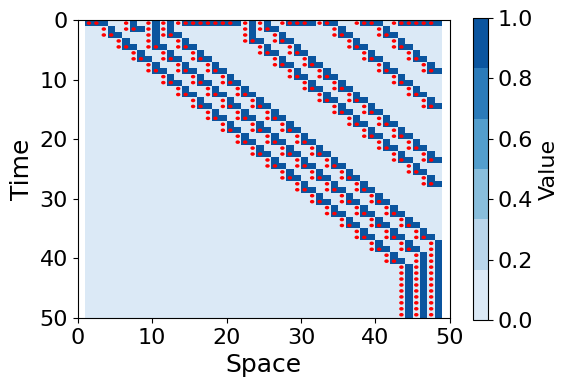

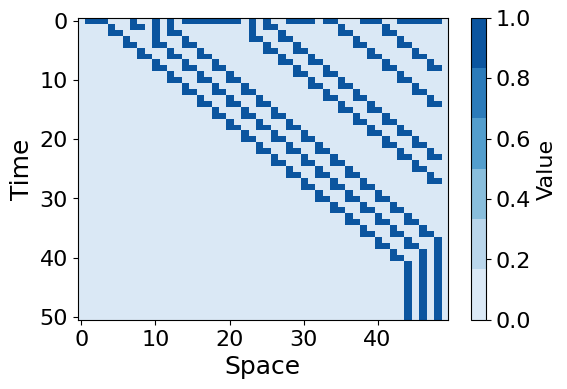

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

import random

def set_plot_info(xlabel,ylabel,title='',fontsize=14):
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.title(title,fontsize=fontsize)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    
def move(strip, markov_matrix,state):
    grid1=np.zeros([1,len(strip)-2])
    cumulative_prob = np.cumsum(markov_matrix, axis=1)
    pattern = int(''.join(str(int(cell)) for cell in strip), state+1)
    value = random.random()
    indices = cumulative_prob[pattern,:] <= value
    interval_indices = np.argmin(indices)
    interval = trans10_to_base(interval_indices, base = state+1, min_length=len(strip)-2)
    grid1[0,:] = np.array(list(map(int, list(interval))))
    return grid1

def generate_markov(p0, rule, middle_size = 1):
    markov_matrix = np.zeros([2**(middle_size+2),2**middle_size])
    binary_string = bin(rule)[2:]  # 将十进制数转换为二进制字符串，并去掉前缀'0b'
    padding_length = 8 - len(binary_string)
    padded_binary_string = '0' * padding_length + binary_string
    
    markov_matrix1 = generate_markov_middleone(p0,rule)
    #print(markov_matrix1)
    
    for i in range(2**(middle_size+2)):
        ii = trans10_to_base(i,min_length=middle_size+2)
        for j in range(2**middle_size):
            j_str = trans10_to_base(j,base=2,min_length=middle_size)
            j_num = [int(q) for q in j_str]
            element = 1
            for k,kk in enumerate(j_num):
                jj = ii[k:k+3]
                jj_indice = int(''.join(str(cell) for cell in jj), 2)
                element = element * markov_matrix1[jj_indice,kk]
       
            markov_matrix[i,j] = element
            #markov_matrix[i,:] += p0 / 2**middle_size
    return markov_matrix

def dgamma(markov_matrix,beta = 2):
    U, original_S, V = np.linalg.svd(markov_matrix, full_matrices=False)
    r = original_S[original_S>(1e-14)].shape[0]
    n = len(original_S)
    original_S = original_S**beta
    #original_gamma = np.sum(original_S)
    d_gamma = np.sum(original_S[:r])/r - np.sum(original_S)/n
    return d_gamma,original_S

def local_gamma(middle_size, e1, e2, markov_matrix, state = 1):
    state_size = (state + 1)**(middle_size)
    local_markov = np.zeros([state_size, state_size])
    for num in range(state_size):
        binary_string = trans10_to_base(num, base = state +1, min_length = middle_size)
        padded_binary_string = e1 + binary_string + e2
        binary_array = [int(bit) for bit in padded_binary_string] 
        pattern = int(''.join(str(cell) for cell in binary_array), state+1)
        local_markov[num, :] = markov_matrix[pattern, :]
    d_gamma,original_S = dgamma(local_markov)
    return d_gamma, local_markov,original_S

def trans10_to_base(number, base = 2, min_length=0):
    
    if min_length < 1:
        raise ValueError("Minimum length must be at least 1")
    
    if number == 0:
        return '0' * min_length

    digits = []
    while number > 0:
        digits.insert(0, str(number % base))
        number //= base

    # 将数字列表转换为字符串，并在前面填充字符以达到最小长度
    padded_digits = ''.join(digits).zfill(min_length)

    return padded_digits

def generate_markov_middleone(p0,rule):
    markov_matrix = np.zeros([8,2])
    binary_string = bin(rule)[2:]  # 将十进制数转换为二进制字符串，并去掉前缀'0b'
    padding_length = 8 - len(binary_string)
    padded_binary_string = '0' * padding_length + binary_string
    for i in range(8):
        ii = trans10_to_base(i,min_length=3)
        jj1 = int(''.join(str(cell) for cell in ii), 2)
        indice = int(padded_binary_string[jj1])
        markov_matrix[i,indice] = 1 - p0
        markov_matrix[i,1-indice] += p0
    return markov_matrix

def cellular_automaton_homo(rule, generations = 100,size=100,middle_size = 1):
    current_generation = [random.randint(0, 1) for _ in range(size)]
    showmatrix = np.zeros([generations+1,size])
    showmatrix[0,:] = current_generation
    
    markov_m = generate_markov(0,rule,middle_size)
        
    gamma_matrix=np.zeros([generations,size-middle_size-1])
    
    binary_string = bin(rule)[2:]  # 将十进制数转换为二进制字符串，并去掉前缀'0b'
    padding_length = 8 - len(binary_string)
    padded_binary_string = '0' * padding_length + binary_string
    state_list = ['0','1']
    S_array = np.zeros([(size-middle_size-1)*generations, 2])
    for k in range(generations):
        next_generation = np.zeros(size)
        current_part = len(current_generation) // middle_size
        # 更新每个元胞的状态
        for i in range(size):
            if i > 0 and i < size-middle_size :
                e1 = str(int(current_generation[i-1]))
                e2 = str(int(current_generation[i+middle_size]))
                d_gamma,_,S = local_gamma(middle_size,e1,e2,markov_m)
#                 print(S)
                S_array[k+k*(i-1),:] = S
                gamma_matrix[k,i-1] = d_gamma 
            if i % middle_size == 0:
                if len(current_generation[i:i+middle_size+2])== middle_size+2:
                    next_generation[i+1:i+middle_size+1] = move(current_generation[i:i+middle_size+2],markov_m,state=1)

        current_generation = next_generation
        showmatrix[k+1,:] = current_generation
        
    fig, ax = plt.subplots(dpi=100)
    ax.clear()
    ax.set_xlim(0, size)
    ax.set_ylim(0, generations)
    ax.set_aspect(0.8)
    ax.invert_yaxis()
    palette = sns.color_palette("Blues")
    cmap = ListedColormap(palette)
    vmin = np.min(gamma_matrix)
    vmax = np.max(gamma_matrix)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    print(gamma_matrix)
#     plt.imshow(gamma_matrix)
#     plt.show()
    for k in range(generations):
        for i in range(1,size-middle_size):
            color_gamma = cmap(norm(gamma_matrix[k,i-1]))  # 根据 gamma 值获取对应的颜色
            color = cmap(norm(showmatrix[k,i]))  # 根据 gamma 值获取对应的颜色
            if showmatrix[k,i] == 1:
#                 circle = plt.Rectangle((i + 0.5, k+0.5), 0.4, edgecolor='none', facecolor='red')
                circle = plt.Rectangle((i, k), 1,1, edgecolor='none', facecolor=color)
                ax.add_patch(circle)
                
            else:
                square = plt.Rectangle((i, k), 1, 1, edgecolor='none', facecolor=color)
                ax.add_patch(square)
            if int(gamma_matrix[k,i-1]) == 1:
#                 de
                small_circle = plt.Circle((i + 0.5, k + 0.5), 0.3, edgecolor='none', facecolor='red')
                ax.add_patch(small_circle)
            

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Value',fontsize=16)
    set_plot_info('Space','Time',fontsize=18)
    plt.show()

    
    fig, ax = plt.subplots(dpi=100)
    plt.imshow(showmatrix,cmap=cmap,aspect=0.8)
    cbar = plt.colorbar(sm)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Value',fontsize=16)
    set_plot_info('Space','Time',fontsize=18)
    plt.show()

    
    return showmatrix,gamma_matrix,S_array
        # 打印当前状态
        #print(''.join(str(cell) for cell in current_generation))

#平稳型   0
#周期型   54  110
#混沌型  30  90
#复杂型  
seed = 2051
random.seed(seed)
np.random.seed(seed)
showmatrix,ei_matrix,S_array = cellular_automaton_homo(rule=40, generations=50, size=50,middle_size=1)
#sns.heatmap(A, annot=True, cmap='Blues')

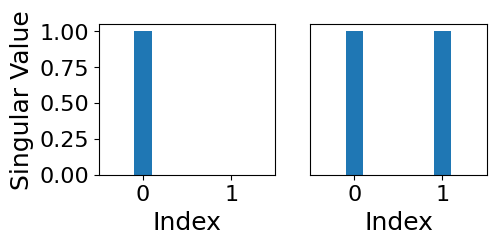

In [85]:

plt.figure(dpi=100,figsize=(5,2))
plt.subplot(121)
plt.bar(range(0,2),[1,0],width=0.2)
plt.xticks([0,1],['0','1'])
set_plot_info('Index','Singular Value',fontsize=18)
plt.xlim(-0.5,1.5)

# plt.figure(dpi=100,figsize=(3,3))
plt.subplot(122)
plt.bar(range(0,2),[1,1],width=0.2)
plt.xticks([0,1],['0','1'])
plt.xlim(-0.5,1.5)
set_plot_info('Index','',fontsize=18)
plt.yticks([])
plt.show()

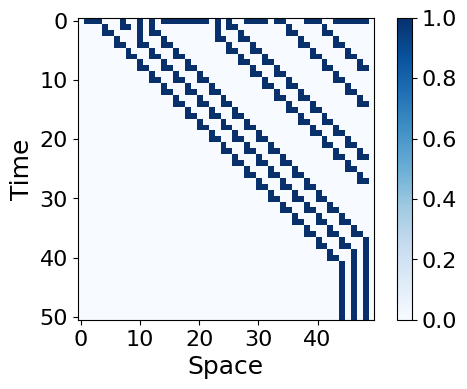

In [13]:
def cellular_automaton(rule, generations, step = 1, sample_size = 1000, size = 100, middle_size = 2, seed = 0):
    # initailize
    random.seed(seed)

    current_generation = [random.randint(0, 1) for _ in range(size)]
    showmatrix=np.zeros([generations+1,size])
    showmatrix[0,:]=current_generation

    if rule==256:
        for k in range(generations):
            next_generation = [random.randint(0, 1) for _ in range(size)]
            showmatrix[k+1,:]=next_generation
    else:    
        binary_string = bin(rule)[2:] 
        padding_length = 8 - len(binary_string)
        padded_binary_string = '0' * padding_length + binary_string
        

        for k in range(generations):
            next_generation = [0] * size
            # update the state
            for i in range(1,size - 1):

                pattern = int(''.join(str(cell) for cell in current_generation[i-1:i+2]), 2)
                next_generation[i] = padded_binary_string[pattern]
                    
                        
            current_generation=next_generation
            showmatrix[k+1,:]=current_generation
             

    return showmatrix
    
plt.figure(dpi=100)
cellular_automaton(rule = 40, generations = 50, step = 1, sample_size = 1000, size = 50, middle_size = 2,seed=2051)
plt.imshow(showmatrix,plt.cm.Blues)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
set_plot_info('Space','Time',fontsize=18)
plt.show()
    